<a href="https://colab.research.google.com/github/Karthik-Pandaram/Machine-learning-projects/blob/main/Signals_lstm_seq2seq_with_strings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt


## Download the data


## Configuration


In [15]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.


## Prepare the data


In [16]:
#Change input text to sequences 
X = list()
Y = list()
def Rand(start, end, num):
    res = []
 
    for j in range(num):
        res.append(np.random.randint(start, end))
 
    return res
 
for i in range(10):
  X.append(Rand(0,50,100))
  Y.append(Rand(0,50,100))

X = np.array(X).reshape(10, 100)
Y = np.array(Y).reshape(10, 100)
inwave = [ ]
tarwave = [ ]
for wav in X:
  l = wav.tolist()
  # Remove square brackets from list
  # using str() + list slicing
  wav = str(l)[1:-1]
  inwave.append(wav)
for wav in Y:
  l = wav.tolist()
  # Remove square brackets from list
  # using str() + list slicing
  wav = str(l)[1:-1]
  tarwave.append(wav)

In [17]:
inwave[1]

'18, 2, 15, 47, 42, 2, 24, 6, 2, 44, 34, 49, 42, 33, 11, 3, 43, 36, 5, 27, 40, 18, 28, 33, 8, 8, 17, 8, 11, 29, 18, 49, 26, 24, 43, 6, 49, 21, 44, 14, 44, 25, 17, 17, 31, 49, 49, 9, 16, 32, 43, 39, 29, 5, 5, 14, 32, 17, 34, 21, 1, 5, 2, 47, 46, 13, 33, 16, 0, 4, 7, 33, 38, 13, 1, 17, 15, 37, 13, 46, 33, 13, 43, 13, 9, 26, 0, 8, 1, 22, 42, 33, 2, 18, 47, 19, 2, 6, 48, 46'

In [18]:
# Vectorize the data.
# inwave = []
# target_texts = []
input_characters = set()
target_characters = set()
# with open(data_path, "r", encoding="utf-8") as f:
#     lines = f.read().split("\n")
for line in inwave:
    # input_text, target_text, _ = line.split("\t")
    # # We use "tab" as the "start sequence" character
    # # for the targets, and "\n" as "end sequence" character.
    # target_text = "\t" + target_text + "\n"
    # input_texts.append(input_text)
    # target_texts.append(target_text)
    for char in line:
        if char not in input_characters:
            input_characters.add(char)
for line in tarwave:            
    for char in line:
        if char not in target_characters:
            target_characters.add(char)

In [19]:
input_characters

{' ', ',', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'}

In [20]:
len(inwave)

10

Character encodind done ok!

In [21]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in inwave])
max_decoder_seq_length = max([len(txt) for txt in tarwave])

print("Number of samples:", len(inwave))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(inwave), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(inwave), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(inwave), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

for i, (input_text, target_text) in enumerate(zip(inwave, tarwave)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

Number of samples: 10
Number of unique input tokens: 12
Number of unique output tokens: 12
Max sequence length for inputs: 385
Max sequence length for outputs: 385


In [22]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])

In [23]:
encoder_input_data

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.]],

       ...,

       [[0., 0., 1., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0.

In [24]:
inwave

['31, 26, 48, 17, 2, 38, 28, 23, 35, 5, 29, 49, 10, 0, 5, 34, 7, 25, 7, 17, 29, 44, 41, 19, 20, 36, 21, 21, 2, 13, 47, 4, 37, 17, 37, 27, 30, 7, 22, 18, 31, 24, 27, 41, 34, 8, 6, 26, 10, 7, 31, 21, 9, 8, 1, 4, 39, 42, 43, 43, 5, 28, 0, 39, 42, 36, 6, 28, 36, 34, 21, 33, 15, 34, 14, 41, 17, 1, 25, 49, 9, 46, 47, 19, 30, 23, 6, 12, 45, 13, 35, 17, 37, 47, 25, 36, 46, 20, 32, 12',
 '18, 2, 15, 47, 42, 2, 24, 6, 2, 44, 34, 49, 42, 33, 11, 3, 43, 36, 5, 27, 40, 18, 28, 33, 8, 8, 17, 8, 11, 29, 18, 49, 26, 24, 43, 6, 49, 21, 44, 14, 44, 25, 17, 17, 31, 49, 49, 9, 16, 32, 43, 39, 29, 5, 5, 14, 32, 17, 34, 21, 1, 5, 2, 47, 46, 13, 33, 16, 0, 4, 7, 33, 38, 13, 1, 17, 15, 37, 13, 46, 33, 13, 43, 13, 9, 26, 0, 8, 1, 22, 42, 33, 2, 18, 47, 19, 2, 6, 48, 46',
 '26, 42, 0, 7, 38, 3, 21, 41, 26, 33, 27, 38, 17, 5, 12, 4, 9, 4, 43, 42, 31, 21, 28, 29, 21, 29, 25, 29, 23, 1, 8, 31, 26, 12, 46, 16, 30, 26, 3, 10, 30, 49, 35, 41, 34, 18, 31, 24, 28, 46, 40, 19, 36, 17, 1, 44, 17, 24, 22, 14, 20, 28, 24, 

## Build the model


In [25]:
# Define an input sequence and process it.
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)


## Train the model


Epoch 1/100
1/1 [==============================] - 6s 6s/step - loss: 2.4951 - accuracy: 0.0578 - val_loss: 2.4010 - val_accuracy: 0.2675
Epoch 2/100
1/1 [==============================] - 2s 2s/step - loss: 2.4006 - accuracy: 0.2685 - val_loss: 2.1999 - val_accuracy: 0.3143
Epoch 3/100
1/1 [==============================] - 2s 2s/step - loss: 2.1906 - accuracy: 0.3120 - val_loss: 2.3907 - val_accuracy: 0.4117
Epoch 4/100
1/1 [==============================] - 2s 2s/step - loss: 2.3874 - accuracy: 0.3883 - val_loss: 2.3586 - val_accuracy: 0.4429
Epoch 5/100
1/1 [==============================] - 2s 2s/step - loss: 2.3546 - accuracy: 0.4292 - val_loss: 2.3168 - val_accuracy: 0.4545
Epoch 6/100
1/1 [==============================] - 2s 2s/step - loss: 2.3110 - accuracy: 0.4591 - val_loss: 2.2446 - val_accuracy: 0.4805
Epoch 7/100
1/1 [==============================] - 2s 2s/step - loss: 2.2377 - accuracy: 0.4867 - val_loss: 2.0732 - val_accuracy: 0.4831
Epoch 8/100
1/1 [=================

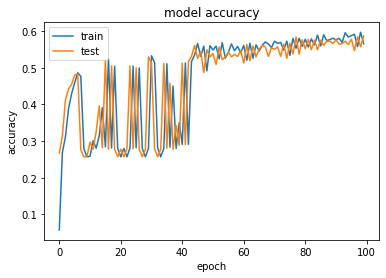

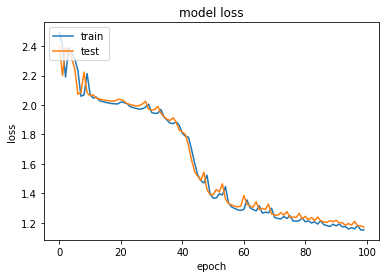

INFO:tensorflow:Assets written to: s2s/assets


INFO:tensorflow:Assets written to: s2s/assets


In [26]:
model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)
history = model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=100,
    validation_split=0.2,
)

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Save model
model.save("s2s")


## Run inference (sampling)

1. encode input and retrieve initial decoder state
2. run one step of decoder with this initial state
and a "start of sequence" token as target.
Output will be the next target token.
3. Repeat with the current target token and current states


In [27]:
plt.savefig("plots.pdf")

<Figure size 432x288 with 0 Axes>

In [41]:
# Define sampling models
# Restore the model and construct the encoder and decoder.
model = keras.models.load_model("s2s")

encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim,))
decoder_state_input_c = keras.Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['0']] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = "0"
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    return decoded_sentence



You can now generate decoded sentences as such:


In [36]:
inwave[1]

'18, 2, 15, 47, 42, 2, 24, 6, 2, 44, 34, 49, 42, 33, 11, 3, 43, 36, 5, 27, 40, 18, 28, 33, 8, 8, 17, 8, 11, 29, 18, 49, 26, 24, 43, 6, 49, 21, 44, 14, 44, 25, 17, 17, 31, 49, 49, 9, 16, 32, 43, 39, 29, 5, 5, 14, 32, 17, 34, 21, 1, 5, 2, 47, 46, 13, 33, 16, 0, 4, 7, 33, 38, 13, 1, 17, 15, 37, 13, 46, 33, 13, 43, 13, 9, 26, 0, 8, 1, 22, 42, 33, 2, 18, 47, 19, 2, 6, 48, 46'

In [37]:
tarwave[1]

'40, 46, 26, 1, 15, 27, 29, 46, 47, 46, 38, 3, 44, 13, 49, 22, 9, 24, 44, 3, 25, 10, 37, 19, 29, 22, 44, 26, 33, 44, 2, 29, 36, 32, 28, 23, 23, 15, 0, 48, 21, 25, 27, 6, 44, 46, 23, 4, 16, 26, 12, 18, 47, 1, 12, 37, 19, 47, 0, 49, 49, 11, 48, 24, 47, 20, 24, 21, 4, 4, 18, 2, 27, 14, 23, 27, 39, 1, 7, 8, 36, 5, 18, 3, 41, 20, 28, 28, 11, 32, 26, 28, 1, 17, 8, 35, 42, 17, 17, 13'

In [43]:
for seq_index in range(2):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_signal = decode_sequence(input_seq)
    print("-")
    print("Input sentence:", inwave[seq_index])
    print("Decoded sentence:", decoded_signal)


-
Input sentence: 31, 26, 48, 17, 2, 38, 28, 23, 35, 5, 29, 49, 10, 0, 5, 34, 7, 25, 7, 17, 29, 44, 41, 19, 20, 36, 21, 21, 2, 13, 47, 4, 37, 17, 37, 27, 30, 7, 22, 18, 31, 24, 27, 41, 34, 8, 6, 26, 10, 7, 31, 21, 9, 8, 1, 4, 39, 42, 43, 43, 5, 28, 0, 39, 42, 36, 6, 28, 36, 34, 21, 33, 15, 34, 14, 41, 17, 1, 25, 49, 9, 46, 47, 19, 30, 23, 6, 12, 45, 13, 35, 17, 37, 47, 25, 36, 46, 20, 32, 12
Decoded sentence: 0, 44, 29, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 
-
Input sentence: 18, 2, 15, 47, 42, 2, 24, 6, 2, 44, 34, 49, 42, 33, 11, 3, 43, 36, 5, 27, 40, 18, 28, 33, 8, 8, 17, 8, 11, 29, 18, 49, 26, 24, 43, 6, 49, 21, 44, 14, 44, 25, 17, 17, 31, 49, 49, 9, 1

# Post processing after inference to convert back to array 

In [42]:
decoded_signal.strip( )
decoded_signal = decoded_signal.replace('[','')
decoded_signal = decoded_signal.replace(']','')
output_signal = np.fromstring(decoded_signal, dtype=int, sep=',')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  after removing the cwd from sys.path.


In [34]:
output_signal

array([], dtype=int64)